In [1]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import datetime
import os

from IPython import display

2.3.0


# Model

## Generator

In [2]:
INPUT_SIZE = 3
OUTPUT_SIZE = 3

def generator_model():
    #Creates a new generator with new weights and no pior training
    #Current model is a simple fully connected with 3-layers depth
    input_shape=(INPUT_SIZE,)
    input1 =  layers.Input(input_shape)

    x = layers.Dense(64)(input1)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(OUTPUT_SIZE)(x)
    
    model = tf.keras.Model(input1,x)
    return model

In [3]:
generator = generator_model()
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)               

## Discriminator

In [4]:
def discriminator_model():
    #Creates a new discriminator with new weights and no pior training
    #Current model is a simple fully connected with 3-layers depth
    input_shape = (OUTPUT_SIZE,)
    data = layers.Input(input_shape)
    
    x = layers.Dense(64)(data)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(1,activation = "sigmoid")(x)
    
    model = tf.keras.Model(data,x)
    return model

In [5]:
discriminator = discriminator_model()
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)               

# Optimizers & Losses

In [6]:
#Adjusted non-saturating gan losses
def generator_loss(fake_output, offset = 0.01):
    return -tf.reduce_mean(tf.math.log(fake_output+offset))

def discriminator_loss(real_output, fake_output, offset=0.01):
    return -tf.reduce_mean(tf.math.log(1-fake_output+offset)) -tf.reduce_mean(tf.math.log(real_output+offset))

In [7]:
#Optmizers for SGD
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training Loop

In [8]:
BATCH_SIZE = 1024

def generate_input_noise(size):
    #use this function to feed the generator
    return tf.random.uniform([size,INPUT_SIZE],minval = 0,maxval = 1)
    #return tf.random.normal([size,INPUT_SIZE])

def generate_target_function(size, sigma = 1):
    #target distribution to be aproximated
    return np.random.lognormal(0,sigma,size = size)

def generate_and_save_histograms(epoch,test_input):
    #Create and save figures to visualize progress
    #use seed to generate predictions
    predictions = generator(test_input, training = False)
    #revert normalization
    predictions = np.array(predictions)*STD+MEAN
    
    #Create figure
    fig_size = (16,4)
    fig, ax = plt.subplots(figsize=fig_size, nrows=1, ncols=OUTPUT_SIZE)
    fig.patch.set_facecolor('white')
    ax = ax.flatten()
    
    #Plot generated and true distribution histograms together
    for i in range(OUTPUT_SIZE):
        ax[i].hist(predictions[:,i],bins = 32,histtype = "step", stacked = "True", linewidth=4, label="Prediction")
        ax[i].hist(generate_target_function(BATCH_SIZE,sigma[i]),
                 color='red', histtype = "step", stacked = "True", bins = 32, linewidth=4, label="Target")
        plt.legend()
    
    #Show and save figure
    plt.savefig(image_log_dir+'\epoch_{:04d}.png'.format(epoch))
    plt.show()

In [9]:
@tf.function
def train_step(data,labels):
    #Traingning step for a single batch
    noise = generate_input_noise(BATCH_SIZE)

    print("Creating graph with:",data.shape)
    with tf.GradientTape(persistent=True) as tape:
        print("Generating data")
        generated_data = generator(noise, training=True)

        print("Calculating discriminator results")
        real_output = discriminator(data, training = True)
        fake_output = discriminator(generated_data, training = True)
        
        print("Calculating loss")
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    print("Calculating gradient")
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    print("Applying gradient")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Train step finished!")
    return gen_loss, disc_loss

In [10]:
def train(Epochs):
    print("Starting training")
    gen_loss=[]
    disc_loss=[]
    for epoch in range(1,Epochs+1):
        start = time.time()

        print("Epoch {}".format(epoch))
        
        g_loss = 0
        d_loss = 0
        for data_batch,labels in dataset:
            g,d = train_step(data_batch,labels)
            
            g_loss = g + g_loss
            d_loss = d + d_loss
        
        gen_loss.append(g_loss)
        disc_loss.append(d_loss)
        
        if(epoch%20==0):
            display.clear_output()
            
            plt.plot(gen_loss,label="Generator")
            plt.plot(disc_loss,label="Discriminator")
            plt.legend()
            plt.show()
            
        if(epoch%20==0):
            generate_and_save_histograms(epoch,seed)
        
        
        print ("Time for epoch {}/{} is {} sec".format(epoch,Epochs, time.time()-start))


# Creating Dataset

Creating Dataset
Dataset histogram


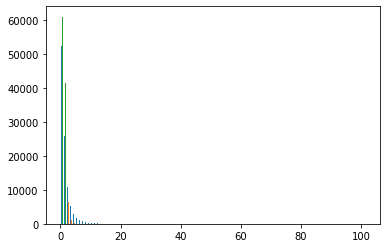

Dataset plot


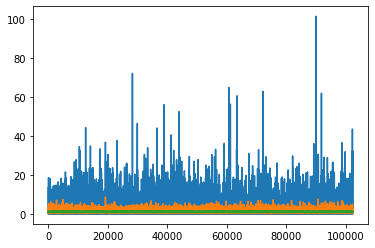

In [11]:
#Dataset parameters
set_size = 100*BATCH_SIZE
dataset_size = OUTPUT_SIZE*set_size
sigma = [1,0.5,0.1]

print("Creating Dataset")
train_data = np.zeros([OUTPUT_SIZE,set_size]).astype("float32")
labels = np.ones([OUTPUT_SIZE,set_size]).astype("float32")
for i in range(OUTPUT_SIZE):
    labels[i] = labels[i]*sigma[i]
    train_data[i] = generate_target_function(set_size,sigma[i])

labels = labels.transpose()
train_data = train_data.transpose()

print("Dataset histogram")
plt.hist(train_data,bins = 100)
plt.show() 

print("Dataset plot")
plt.plot(train_data)
plt.show()

#Normalization
MEAN = np.mean(train_data)
STD = np.std(train_data)  
train_data = (train_data - MEAN)/STD

#Discriminator/Generator test
discriminator(generator(generate_input_noise(BATCH_SIZE)))

dataset = tf.data.Dataset.from_tensor_slices((train_data, labels))
dataset = dataset.shuffle(2*BATCH_SIZE).batch(BATCH_SIZE)



# Training and testing

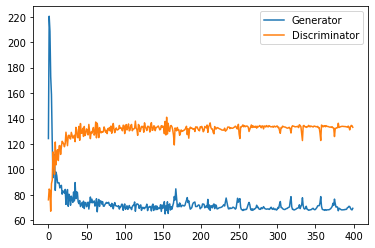

No handles with labels found to put in legend.
No handles with labels found to put in legend.


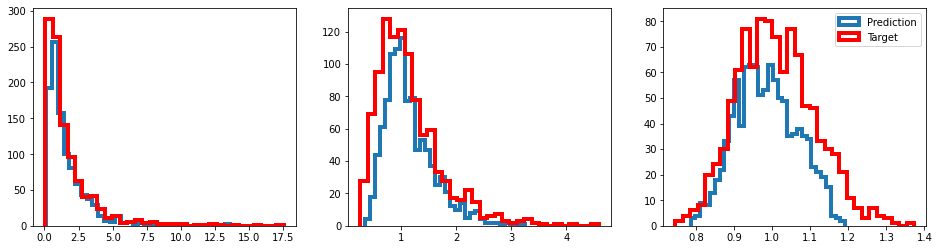

Time for epoch 400/400 is 0.7335832118988037 sec


In [12]:
for _ in range(1):
    seed = generate_input_noise(BATCH_SIZE)

    generator = generator_model()
    discriminator = discriminator_model()

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    metric_log_dir = 'logs/metric/'+ current_time
    metric_summary_writer = tf.summary.create_file_writer(metric_log_dir)

    image_log_dir = 'logs/images/'+ current_time 
    os.makedirs(image_log_dir)

    tf.keras.utils.plot_model(generator,to_file=image_log_dir+"\gen_gan.png",show_shapes=False)
    tf.keras.utils.plot_model(discriminator,to_file=image_log_dir+"\disc_gan.png",show_shapes=False)

    train(400)